# Квадратичная задача о назначениях

## Описание задачи

**Квадратичная задача о назначениях (QAP)** - одна из фундаментальных задач комбинаторной оптимизации в области оптимизации.  
Задача моделирует следующую реальную проблему:
> Имеется набор из $n$ объектов и набор из $n$ мест. Для каждой пары местоположений указывается расстояние, а для каждой пары объектов указывается вес или расход (например, количество материалов, перевозимых между двумя объектами). Проблема состоит в том, чтобы разместить все объекты в разных местах с целью минимизировать сумму расстояний, умноженных на соответствующие потоки.

Интуитивно, функция затрат побуждает **объекты с большими потоками между собой располагаться близко друг к другу**.  
Постановка задачи похожа на задачу о назначениях , за исключением того, что функция стоимости выражается в виде квадратичных неравенств.  

Формальное определение квадратичной задачи о назначениях выглядит следующим образом:
> Даны два набора, $P$ (объекты) и $L$ (местоположения) одинакового размера вместе с функцией веса $w: P * P \to \mathbb{R}$ и функцией расстояния $d: L * L \to \mathbb{R}$. Найдите биекцию (взаимо-однозначное соответствие) $f: P \to L$ (назначение) такое, что функция стоимости:
> $$\sum_{a,b \in P}\omega(a, b)*d(f(a),f(b))$$
> сведена к минимуму.

Обычно функции веса и расстояния рассматриваются как квадратные матрицы с действительными значениями, поэтому функция стоимости записывается как:
$$\sum_{a,b \in P}\mathrm{\omega}_{a,b}\mathrm{d}_{f(a),f(b)}$$
В матричных обозначениях:
$$\min_{X \in \mathrm{\Pi}_{n}} \text{trace}(WXDX^T)$$
Где $\mathrm{\Pi}_{n}$ - это набор $n*n$ матрицы перестановок, $W$ - весовая матрица, $D$ - матрица расстояний  

Задача является NP-трудной, потому не существует известного алгоритма решения этой задачи за полиномиальное время.  
Также было доказано, что задача не имеет алгоритма аппроксимации, работающего за полиномиальное время для любого (постоянного) фактора, кроме случаев, когда P = NP.  

Задачу коммивояжера (TSP) можно рассматривать как частный случай QAP, если предположить, что потоки соединяют все предприятия только по одному кольцу, все потоки имеют одно и то же ненулевое (постоянное) значение и все расстояния равны равны соответствующим расстояниям экземпляра TSP.  
Многие другие задачи стандартной комбинаторной оптимизации могут быть записаны в этой форме.

## Реализация решения задачи

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from graphviz_drawer import graphviz_drawer
from assignement_problem import assignement_problem_ga, assignement_problem_faq, assignement_problem_2opt
from fitness import compute_fitness_scores
from reader_datasets import download_datasets_to_file, get_all_datasets_from_file

### Параметры

In [10]:
MUTATION_PROBABILITY = 0.08
CROSSOVER_PROBABILITY = 0.7

### Датасеты

Датасеты для задачи были взяты с сайта [coral.ise.lehigh.edu](https://coral.ise.lehigh.edu/data-sets/qaplib/qaplib-problem-instances-and-solutions/).  
Экземпляры авторства E.D. Taillard с предложенными решениями. Эффективность алгоритмов будет сравниваться с данными решениями.  
Автор указывает полученный им счёт. Для проверки написанной метрики был подсчитан счёт для двух случайно выбранных решений и сравнен с указанным.

In [11]:
# download_datasets_to_file()

In [12]:
datasets = get_all_datasets_from_file()
for dataset in datasets:
    if dataset['n'] == 12:
        score = compute_fitness_scores([8,1,6,2,11,10,3,5,9,7,12,4], 
                                       np.array(dataset['distance_matrix']), 
                                       np.array(dataset['flow_matrix']))
        assert score == 224416
    if dataset['n'] == 25:
        score = compute_fitness_scores([9,4,6,11,5,1,15,10,14,3,17,12,19,18,23,8,21,2,22,7,16,20,24,25,13], 
                                       np.array(dataset['distance_matrix']), 
                                       np.array(dataset['flow_matrix']))
        assert score == 1167256


In [13]:
solutions = {}

### Генетический алгоритм

**Генетический алгоритм** представляет собой метаэвристику, вдохновлённую процессоми естественного отбора и принадлежит к классу **эволюционных алгоритмов**.  
Алгоритм имеет биологически вдохновлённые операторы, такие как **мутация**, **скрещивание** и **отбор**.  
Так как алгоритм ялвяется метаэвристикой, не существует общего анализа временной сложности, однако генетическеие алгоритмы прохо масштабируются под сложность решаемой проблемы. Следоватенльно, **если мы имеем большой размер области поика решений, то число подверженных мутации элементов будет очень велико**.   
Алгоритм требует:
1. Генетическое представление области решения;
2. Фитнес- функцию для оценки области решения.

Оба пукта были описаны в разделе описания задачи выше и были реализованы.  
Функцию фитнеса необходимо сводить к **минимуму**, её значение будет расти с увеличением размера датасетов, потому их значение относительно друг друга не показательно. Сравнение будет проводиться с вычетом счёта решения, предложенного автором датасета.  
В общем случае алгоритм можно расписать следующим образом:
1. Задание целевой функции для особей популяции;
2. Создание начальной популяции;
3. Цикл:
    1. Скрещивание / размножение (генерирует новое рещение из двух существующих);
    2. Мутирование (необходимо для поддержания генетического разнообразия от одного поколения к другому, а так же для предотвращения застревания алгоритма в локальном минимуме или сходимости на субоптимальном решении);
    3. Вычисление значения целевой функции для всех особей;
    4. Формирование нового поколения (селекция);
    5. Конец цикла, если выполняются условия остановки, иначе следующая итерация.

В данной реализации можно задать следующие параметры алгоритма:
- Размер популяции (`population_size`);
- Вероятность скрещивания (`crossover_probability`). Чем ниже данный параметр, тем сильнее новые решения будут похожи на родительские;
- Вероятность мутации (`mutation_probability`). Чем ниже данный параметр, тем меньше процент популяцими, который мутирует в каждом поколении;
- Условие окончания цикла по количеству итераций (`number_of_generation`);
- Условие окончания цикла по времени выполнения (`time_limit`). *Необязательный параметр.* Фактическое время может быть больше, так как текущая эпоха будет завершена в любом случае;
- Условие окончания цикла по количеству эпох без улучшения лучшего результата (`max_generations_no_improve`) *Необязательный параметр.*

Оптимизация параметров в данной реализации проводиться не будет.

Реализация генетического алгоритма вынесена в отдельные модули, в данном ноутбуке приведён только анализ результатов работы алгоритма.

In [14]:
res_ga = assignement_problem_ga(
    distance_matrix=datasets[0]['distance_matrix'],
    flow_matrix=datasets[0]['flow_matrix'],
    population_size=40,
    number_of_generations=100,
    crossover_probability=CROSSOVER_PROBABILITY,
    mutation_probability=MUTATION_PROBABILITY)

res_ga

{'time': 0.1733994483947754,
 'epoch': 99,
 'average_fitness': 243227.65,
 'max_fitness': 242120,
 'max_solution': [5, 10, 9, 3, 11, 4, 7, 6, 2, 8, 1, 12]}

In [15]:
datasets[0]['score']

224416

In [16]:
compute_fitness_scores([8,1,6,2,11,10,3,5,9,7,12,4], datasets[0]['distance_matrix'], datasets[0]['flow_matrix'])

224416

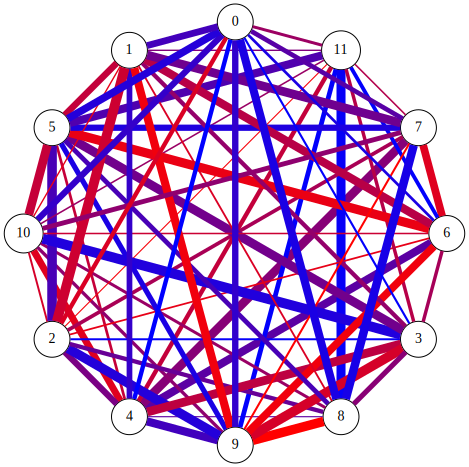

In [17]:
display(graphviz_drawer(datasets[0]['distance_matrix'], datasets[0]['flow_matrix'], res_ga['max_solution']))

На рисунке толщина линий отвечает за вес (ширину потока), а цвет линии - за расстояние (синий - ближе, красный - дальше).  
Интуитивное решение стремится к синим толстым стрелкам и тонким красным

In [18]:
solutions['ga'] = pd.DataFrame(columns=['matrix_size', 'time', 'epoch', 'score', 'reference_score'])

for dataset in datasets:
    res_ga = assignement_problem_ga(
        distance_matrix=dataset['distance_matrix'],
        flow_matrix=dataset['flow_matrix'],
        population_size=40,
        number_of_generations=100,
        crossover_probability=CROSSOVER_PROBABILITY,
        mutation_probability=MUTATION_PROBABILITY,
        max_generations_no_improve=10)
    
    solutions['ga'].loc[len(solutions['ga'])] = [dataset['n'], res_ga['time'], res_ga['epoch'], res_ga['max_fitness'], dataset['score']]

solutions['ga']


,matrix_size,time,epoch,score,reference_score
0,12.0,0.162388,99.0,244742.0,224416.0
1,15.0,0.260733,99.0,411524.0,388214.0
2,17.0,0.315627,99.0,520102.0,491812.0
3,20.0,0.416085,99.0,769228.0,703482.0
4,25.0,0.619302,99.0,1296896.0,1167256.0
5,30.0,0.869141,99.0,1984282.0,1818146.0
6,35.0,1.189592,99.0,2679988.0,2422002.0
7,40.0,1.502004,99.0,3462198.0,3139370.0
8,50.0,2.322843,99.0,5459948.0,4938796.0
9,60.0,3.343940,99.0,8091582.0,7205962.0


### Сравнение генетического алгоритма (GA), алгоритма быстрой аппроксимации (FAQ) и алгоритма 2-opt

Были рассмотрены алгоритмы быстрой аппроксимации и 2-opt.  

**Алгоритм быстрой аппроксимации (Fast Approximate QAP - FAQ)** и **Алгоритм 2-opt** можно рассмотреть, как нахождение выравнивания узлов двух графов, которое минимизирует количество индуцированных нессответствий рёбер или, в случае взвешенных графов, сумму квадратов весов ребёр.  
Так как задача QAP является NP-трудной, оба алгоритма выдают приблизительный результат и не гарантируют, что он будет оптимальным.  
Учитывая **ограниченное число итераций** оба алгоритма имеют сложность $O=(n^3)$, однако **FAQ** так же имеет очень малые ведущие константы ($\approx 10^{-9}$)  
Это говорит о том, что алгоритм **FAQ** может быть применим для сопоставления даже достаточно больших графов.  

**FAQ** чуствителен к исходной матрице перестановок из-за возможности нескольких локальных минимумов в допустимой области. Инициализация барицентра с большей вероятностью приведёт к лучшему решению, чем одиночная случайная инициализация. Потому в дальшейшем FAQ будет запускаться **исключительно с рандомизированной инициализацией**  

**Алгоритм 2-opt** является жадным алгоритмом, который работает аналогично пузырьковой сортировке: начиная с начальной перестановки он итеративно меняет местами пары индексов для улучшения целевой функции до тех пор, пока такие улучшения не станут невозможными.  

In [19]:
solutions['faq'] = pd.DataFrame(columns=['matrix_size', 'time', 'score', 'reference_score'])

for dataset in datasets:
    res_faq = assignement_problem_faq(
        distance_matrix=dataset['distance_matrix'],
        flow_matrix=dataset['flow_matrix'])
    
    solutions['faq'].loc[len(solutions['faq'])] = [dataset['n'], res_faq['time'], res_faq['max_fitness'], dataset['score']]

solutions['faq']

,matrix_size,time,score,reference_score
0,12.0,0.008006,244366.0,224416.0
1,15.0,0.002006,412590.0,388214.0
2,17.0,0.002004,535940.0,491812.0
3,20.0,0.002001,745838.0,703482.0
4,25.0,0.002507,1210560.0,1167256.0
5,30.0,0.003005,1889972.0,1818146.0
6,35.0,0.004565,2486648.0,2422002.0
7,40.0,0.005006,3274612.0,3139370.0
8,50.0,0.007515,5167170.0,4938796.0
9,60.0,0.009240,7390788.0,7205962.0


In [20]:
solutions['2opt'] = pd.DataFrame(columns=['matrix_size', 'time', 'score', 'reference_score'])

for dataset in datasets:
    res_2opt = assignement_problem_2opt(
        distance_matrix=dataset['distance_matrix'],
        flow_matrix=dataset['flow_matrix'])
    
    solutions['2opt'].loc[len(solutions['2opt'])] = [dataset['n'], res_2opt['time'], res_2opt['max_fitness'], dataset['score']]

solutions['2opt']

,matrix_size,time,score,reference_score
0,12.0,0.003514,241866.0,224416.0
1,15.0,0.003999,424168.0,388214.0
2,17.0,0.006512,515832.0,491812.0
3,20.0,0.008410,746136.0,703482.0
4,25.0,0.022029,1235708.0,1167256.0
5,30.0,0.034111,1899508.0,1818146.0
6,35.0,0.030531,2566948.0,2422002.0
7,40.0,0.054004,3341552.0,3139370.0
8,50.0,0.173301,5202044.0,4938796.0
9,60.0,0.325047,7554148.0,7205962.0


In [21]:
comp = pd.merge(solutions['ga'], solutions['faq'], on=['matrix_size', 'reference_score'] , suffixes=['_ga', '_faq']).merge(
    solutions['2opt'], on=['matrix_size', 'reference_score'])
comp = comp.rename(columns = {'time': 'time_2opt', 'score': 'score_2opt'})
comp = comp[['matrix_size', 'time_ga', 'time_faq', 'time_2opt', 'score_ga', 'score_faq', 'score_2opt', 'reference_score']]
comp

,matrix_size,time_ga,time_faq,time_2opt,score_ga,score_faq,score_2opt,reference_score
0,12.0,0.162388,0.008006,0.003514,244742.0,244366.0,241866.0,224416.0
1,15.0,0.260733,0.002006,0.003999,411524.0,412590.0,424168.0,388214.0
2,17.0,0.315627,0.002004,0.006512,520102.0,535940.0,515832.0,491812.0
3,20.0,0.416085,0.002001,0.008410,769228.0,745838.0,746136.0,703482.0
4,25.0,0.619302,0.002507,0.022029,1296896.0,1210560.0,1235708.0,1167256.0
5,30.0,0.869141,0.003005,0.034111,1984282.0,1889972.0,1899508.0,1818146.0
6,35.0,1.189592,0.004565,0.030531,2679988.0,2486648.0,2566948.0,2422002.0
7,40.0,1.502004,0.005006,0.054004,3462198.0,3274612.0,3341552.0,3139370.0
8,50.0,2.322843,0.007515,0.173301,5459948.0,5167170.0,5202044.0,4938796.0
9,60.0,3.343940,0.009240,0.325047,8091582.0,7390788.0,7554148.0,7205962.0


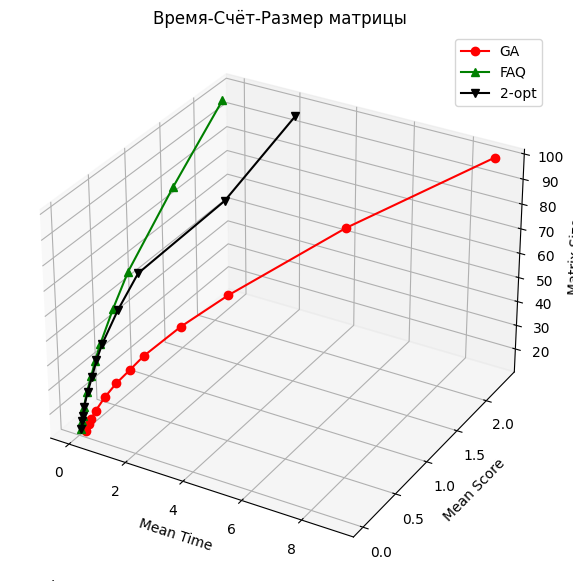

In [22]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(projection='3d')
ax.plot(solutions['ga'].time, solutions['ga'].score, solutions['ga'].matrix_size, 'o-r', label='GA')
ax.plot(solutions['faq'].time, solutions['faq'].score, solutions['faq'].matrix_size, '^-g', label='FAQ')
ax.plot(solutions['2opt'].time, solutions['2opt'].score, solutions['2opt'].matrix_size, 'v-k', label='2-opt')
ax.set_title('Время-Счёт-Размер матрицы')
ax.set_xlabel('Mean Time')
ax.set_ylabel('Mean Score')
ax.set_zlabel('Matrix Size')
ax.legend()

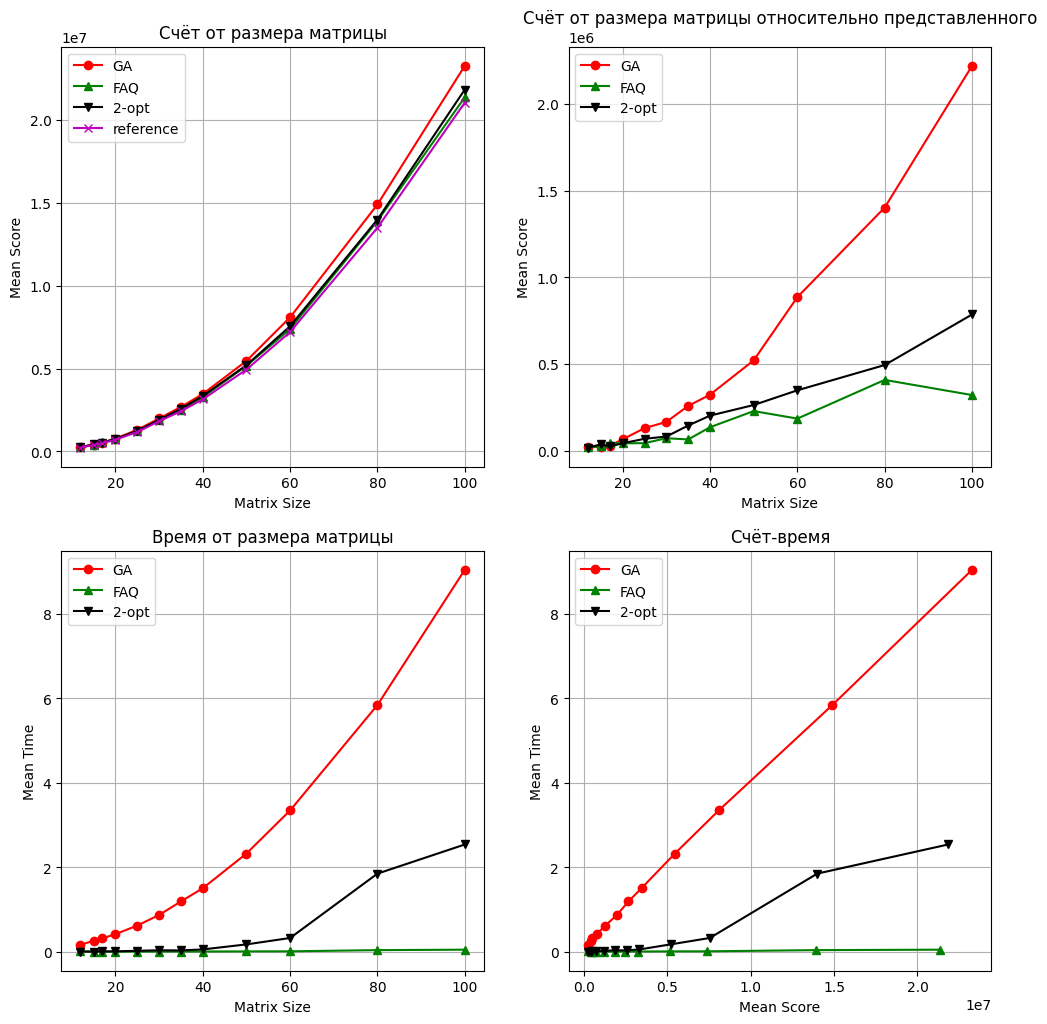

In [24]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.title('Счёт от размера матрицы')
plt.plot(solutions['ga'].matrix_size, solutions['ga'].score, 'o-r', label='GA')
plt.plot(solutions['faq'].matrix_size, solutions['faq'].score, '^-g', label='FAQ')
plt.plot(solutions['2opt'].matrix_size, solutions['2opt'].score, 'v-k', label='2-opt')
plt.plot(solutions['ga'].matrix_size, solutions['ga'].reference_score, 'x-m', label='reference')
plt.xlabel('Matrix Size')
plt.ylabel('Mean Score')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Счёт от размера матрицы относительно представленного')
plt.plot(solutions['ga'].matrix_size, solutions['ga'].score - solutions['ga'].reference_score, 'o-r', label='GA')
plt.plot(solutions['faq'].matrix_size, solutions['faq'].score - solutions['ga'].reference_score, '^-g', label='FAQ')
plt.plot(solutions['2opt'].matrix_size, solutions['2opt'].score - solutions['ga'].reference_score, 'v-k', label='2-opt')
plt.xlabel('Matrix Size')
plt.ylabel('Mean Score')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('Время от размера матрицы')
plt.plot(solutions['ga'].matrix_size, solutions['ga'].time, 'o-r', label='GA')
plt.plot(solutions['faq'].matrix_size, solutions['faq'].time, '^-g', label='FAQ')
plt.plot(solutions['2opt'].matrix_size, solutions['2opt'].time, 'v-k', label='2-opt')
plt.xlabel('Matrix Size')
plt.ylabel('Mean Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.title('Счёт-время')
plt.plot(solutions['ga'].score, solutions['ga'].time, 'o-r', label='GA')
plt.plot(solutions['faq'].score, solutions['faq'].time, '^-g', label='FAQ')
plt.plot(solutions['2opt'].score, solutions['2opt'].time, 'v-k', label='2-opt')
plt.xlabel('Mean Score')
plt.ylabel('Mean Time')
plt.legend()
plt.grid(True)